In [3]:
from sqlalchemy import create_engine, MetaData
from sqlalchemy import select, func 
from db_schema import OIL_PROD_TABLE, GAS_PROD_TABLE, LEASE_TABLE, WELLS_TABLE, TOPS_TABLE
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [4]:
engine = create_engine("sqlite:///../../kansas_oil_gas.db")
# Reflect oil production table
meta = MetaData()
meta.reflect(bind=engine)
oil_prod = meta.tables[OIL_PROD_TABLE]
gas_prod = meta.tables[GAS_PROD_TABLE]
lease = meta.tables[LEASE_TABLE]
wells = meta.tables[WELLS_TABLE]
tops = meta.tables[TOPS_TABLE]


In [5]:
s = select(
    [
        oil_prod.c.DATE,
        func.sum(oil_prod.c.WELLS).label("N_WELLS"),
        func.sum(oil_prod.c.PRODUCTION).label("MONTHLY_OIL_PROD"),
    ]
).group_by(oil_prod.c.DATE)
df_oil_prod = pd.read_sql(s, engine)

Check the relationship between number of wells to oil production. We should see a positive correlation with numbers of wells to production. 

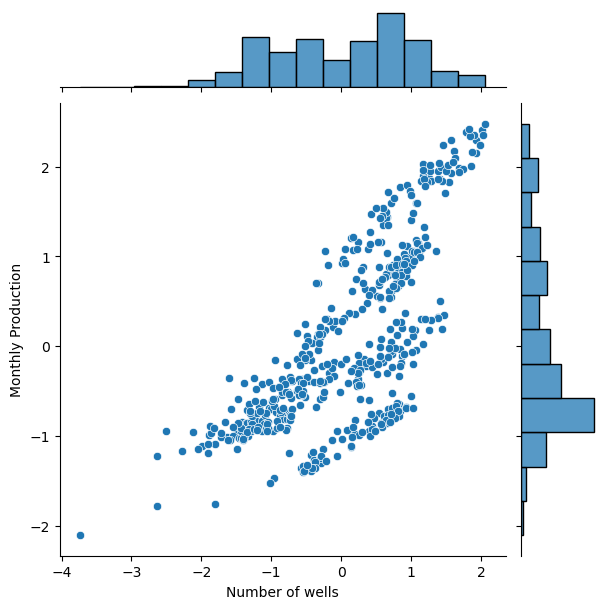

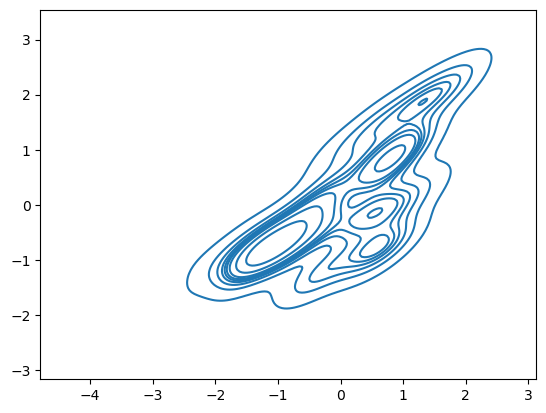

In [6]:
scale = StandardScaler()
nwells_scaled = scale.fit_transform(np.asarray(df_oil_prod["N_WELLS"])[:,None]).ravel()
oil_prod_scaled = scale.fit_transform(np.asarray(df_oil_prod["MONTHLY_OIL_PROD"])[:,None]).ravel()
sns.jointplot(x=nwells_scaled,y=oil_prod_scaled)
plt.xlabel("Number of wells")
plt.ylabel("Monthly Production")
plt.show()

sns.kdeplot(x=nwells_scaled,y=oil_prod_scaled)
plt.show()

There seems to be some clustering within the data as different sections of data seems to have a different relationship. Since these are time series, they might be seasonal effects, or technology effects (better technology throughout the years lead to increase in production from the same amount of wells), or even decom of new wells along with new wells giving the impression of increased production for the same number of wells.

Need to investigate how production varies in each lease? Maybe how lease start/end affects clustering? Geographic location?

In [7]:
kansas_prod = gpd.read_file("Shapefiles/OILGAS_FIELDS_GEO.shp")
kansas_poly = gpd.read_file("Shapefiles/kansas_poly.geojson")
kansas_state = gpd.read_file("Shapefiles/tl_2017_20_cousub.shp")

In [8]:
s = select(
    [
        lease.c.COUNTY,
        lease.c.PRODUCES,
        lease.c.PRODUCTION,
        lease.c.YEAR_START,
        lease.c.YEAR_STOP,
        lease.c.LATITUDE,
        lease.c.LONGITUDE
    ]
).where(lease.c.PRODUCTION != None)
df_lease = pd.read_sql(s, engine)
geometry = [Point(xy) for xy in zip(df_lease['LONGITUDE'],df_lease['LATITUDE'])]
df_lease = gpd.GeoDataFrame(df_lease, geometry=geometry, crs = kansas_state.crs)

# Get production average per year for each lease to see which counties have the most prolific production
df_lease['year_span'] = (df_lease['YEAR_STOP'] - df_lease['YEAR_START']).apply(lambda x: max(x,1))
df_lease["yearly_production"] = df_lease['PRODUCTION'] / df_lease['year_span']

In [9]:
s = select(
    [
        lease.c.COUNTY,
        lease.c.PRODUCES,
        lease.c.PRODUCTION,
        lease.c.YEAR_START,
        lease.c.YEAR_STOP,
        lease.c.LATITUDE,
        lease.c.LONGITUDE
    ]
).where(lease.c.PRODUCTION != None)
df_lease = pd.read_sql(s, engine)
geometry = [Point(xy) for xy in zip(df_lease['LONGITUDE'],df_lease['LATITUDE'])]
df_lease = gpd.GeoDataFrame(df_lease, geometry=geometry, crs = kansas_state.crs)

# Get production average per year for each lease to see which counties have the most prolific production
df_lease['year_span'] = (df_lease['YEAR_STOP'] - df_lease['YEAR_START']).apply(lambda x: max(x,1))
df_lease["yearly_production"] = df_lease['PRODUCTION'] / df_lease['year_span']

In [43]:
df_lease_gas = df_lease[df_lease['PRODUCES'] == 'GAS'].reset_index(drop=True)
df_lease_oil = df_lease[df_lease['PRODUCES'] == 'OIL'].reset_index(drop=True)

# Rank leases
df_lease_gas['rank'] = pd.Categorical(np.ceil(df_lease_gas['yearly_production'].rank(pct=True).mul(4)).astype('Int64'))
df_lease_oil['rank'] = pd.Categorical(np.ceil(df_lease_oil['yearly_production'].rank(pct=True).mul(4)).astype('Int64'))


C:\Users\Geetak\AppData\Local\Temp\ipykernel_21948\2102078770.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Geetak\AppData\Local\Temp\ipykernel_21948\2102078770.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


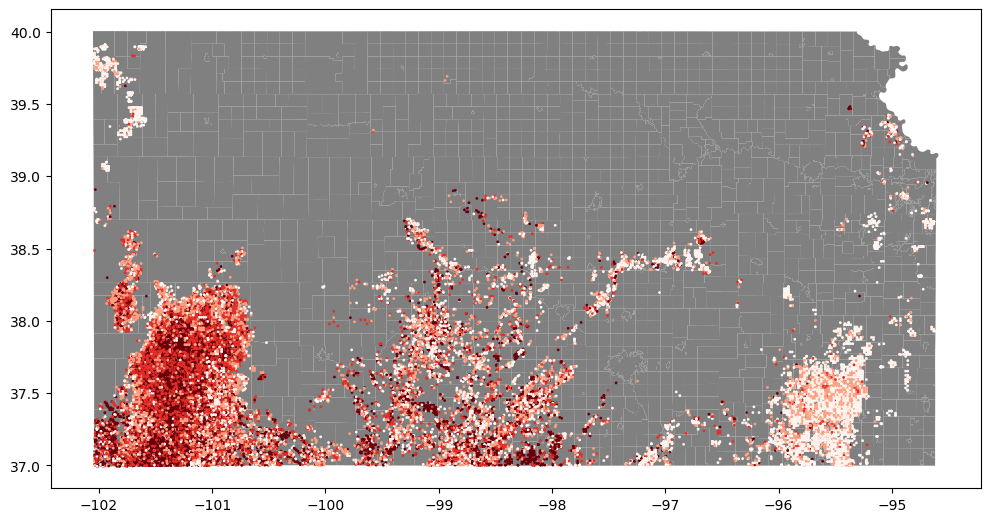

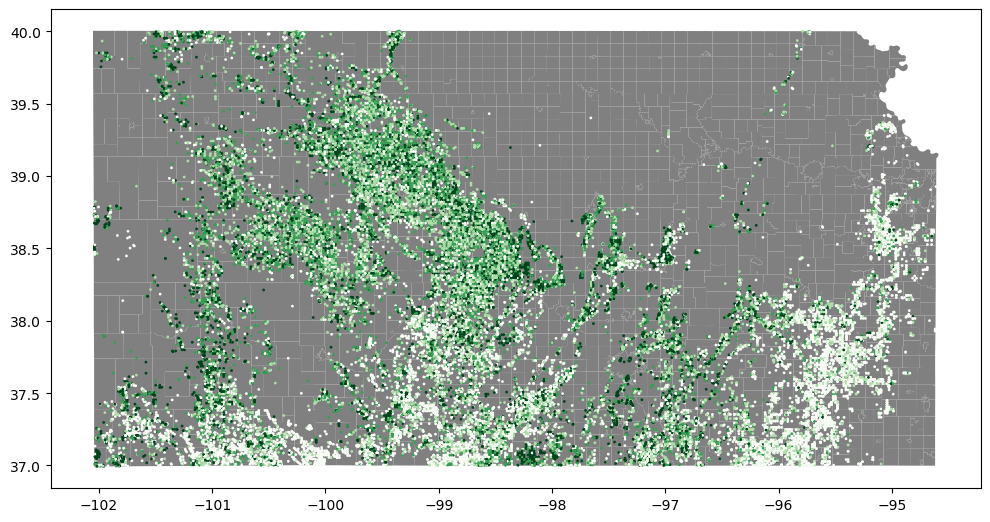

In [49]:
fig, ax = plt.subplots(figsize = (12,10))
kansas_state.plot(ax = ax, color = 'grey')
df_lease_gas.plot(ax = ax, cmap = 'Reds', column = 'rank', markersize = 1)
#df_lease_oil.plot(ax = ax, cmap = 'Greens', column = 'rank', markersize = 1)
fig.show()

fig, ax = plt.subplots(figsize = (12,10))
kansas_state.plot(ax = ax, color = 'grey')
#df_lease_gas.plot(ax = ax, cmap = 'Reds', column = 'rank', markersize = 1)
df_lease_oil.plot(ax = ax, cmap = 'Greens', column = 'rank', markersize = 1)
fig.show()